In [1]:
import spec
import jax.numpy as jnp
from ark.cdg.cdg import CDG, CDGEdge, CDGNode
from ark.specification.cdg_types import EdgeType, NodeType
from ark.ark import Ark
import matplotlib.pyplot as plt
import numpy as np

system = Ark(cdg_spec=spec.obc_tln_spec)

16


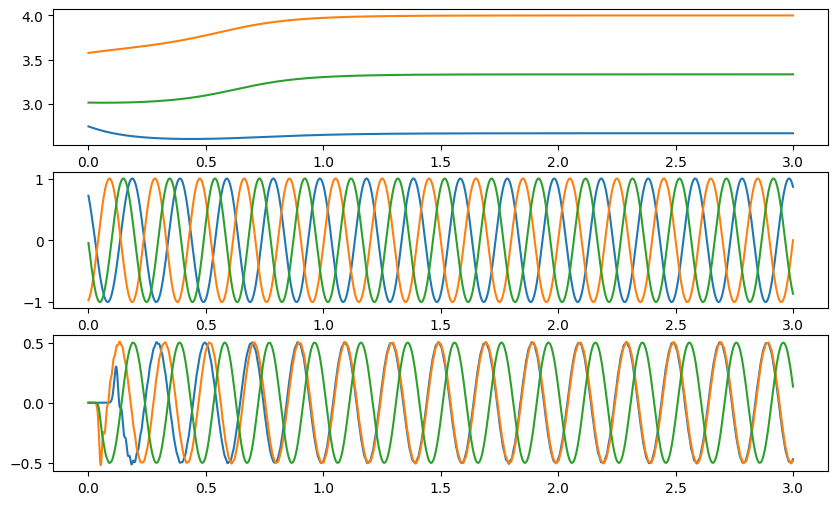

In [2]:
# Test osc2v conversion
np.random.seed(0)
def locking_fn(x, lock_strength: float):
    "Injection locking function with phase normalize from pi to 1"
    return lock_strength * jnp.sin(3 * np.pi * x)


def coupling_fn(x, cpl_strength: float):
    "Oscillator coupling function with phase normalize from pi to 1"
    return cpl_strength * jnp.sin(np.pi * x)

def sin_fn(x):
    "Sine function with phase normalize from pi to 1"
    return jnp.sin(x)

def mk_lines(graph: CDG, length: int, lc_val: float):
    "Make a line of LC elements with matched load impedance"
    lcs = [spec.IdealV(c=lc_val, g=1)]
    graph.connect(spec.IdealE(), lcs[0], lcs[0])
    prev_c = lcs[0]
    for i in range(length):
        ind, cap = spec.IdealI(l=lc_val, r=0), spec.IdealV(c=lc_val, g=0)
        lcs.extend([ind, cap])
        graph.connect(spec.IdealE(), prev_c, ind)
        graph.connect(spec.IdealE(), ind, cap)
        prev_c = cap
        # Omit the self connection because g and r are set to 0 anyway
    prev_c.attrs["g"] = 1
    graph.connect(spec.IdealE(), prev_c, prev_c)
    for ele in lcs:
        ele.set_init_val(val=0, n=0)
    return lcs

graph = CDG()
time_points = jnp.linspace(0, 3, 10000)
node_attrs = {
    "lock_fn": locking_fn,
    "osc_fn": coupling_fn,
    "lock_strength": 0.5,
    "cpl_strength": 0.5,
}
n_oscs = 3
wave_freq = 5
one_period = 1 / wave_freq

base_n_sections = 10
lc_val = 1 / 50 / wave_freq
tline_velocity = 1 / lc_val
one_section_time = 1 / tline_velocity
n_sections_for_one_third_period = int(one_period / one_section_time / 3)
print(n_sections_for_one_third_period)

oscs = [spec.Osc(**node_attrs) for _ in range(n_oscs)]
lcss = [mk_lines(graph, length=base_n_sections + n_sections_for_one_third_period, lc_val=lc_val)] + [mk_lines(graph, length=base_n_sections, lc_val=lc_val) for _ in range(n_oscs - 1)]

init_phases_normalized = np.random.rand(n_oscs) * 5
for i, (osc, lcs) in enumerate(zip(oscs, lcss)):
    graph.connect(spec.Coupling(k=-1.0), osc, oscs[(i + 1) % n_oscs])   
    graph.connect(spec.Coupling(k=1.0), osc, osc)
    osc.set_init_val(init_phases_normalized[i], n=0)

    p2v_edge = spec.Phase2VoltE(
        f=wave_freq,
        sin=sin_fn,
    )
    graph.connect(p2v_edge, osc, lcs[0])





system.compile(cdg=graph)
system.execute(cdg=graph, time_eval=time_points)
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
for i, osc in enumerate(oscs):
    traj = osc.get_trace(n=0)
    axes[0].plot(time_points, traj, label=f"Oscillator {i}")
    axes[1].plot(time_points, np.sin(2 * np.pi * wave_freq * time_points + np.pi * traj))

for i, lcs in enumerate(lcss):
    traj = lcs[-1].get_trace(n=0)
    axes[2].plot(time_points, traj, label=f"Voltage {i}")



Oscillator 0 0 init_val: 2.7440675196366238
Oscillator 0 1 init_val: 3.5759468318620975
Oscillator 1 0 init_val: 3.7440675196366238
Oscillator 1 1 init_val: 4.5759468318620975


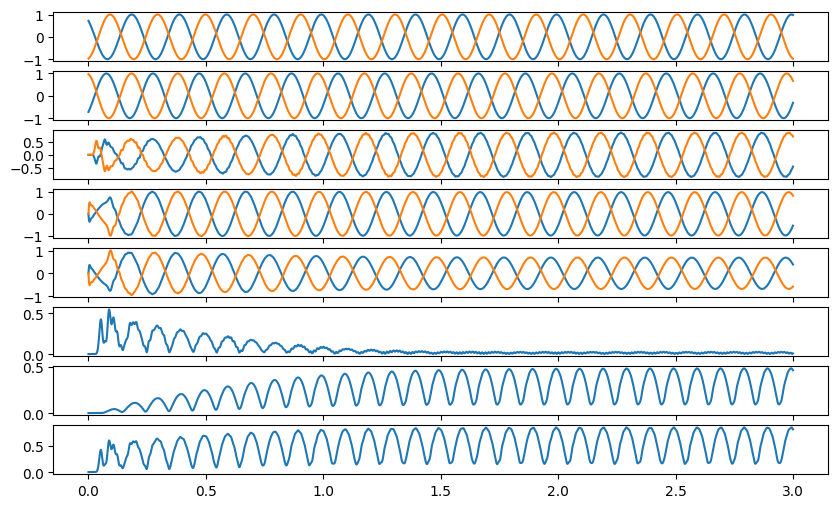

In [8]:
# Example: Computing phase difference of 2 oscillator vectors
n_vec = 2
vec_len = 2

def mk_merge_lines(graph: CDG, length: int, lc_val: float):
    "Make 2 t-lines merged together in the middle"
    half_length = length // 2

    lcs = [[], []]
    middle_cap = spec.IdealV(c=lc_val, g=0)
    for i in range(2):
        prev_ind = None
        for j in range(half_length):
            cap, ind = spec.IdealV(c=lc_val, g=0), spec.IdealI(l=lc_val, r=0)
            lcs[i].extend([cap, ind])
            graph.connect(spec.IdealE(), cap, ind)
            if j:
                graph.connect(spec.IdealE(), prev_ind, cap)
            else:
                cap.attrs["g"] = 1
                graph.connect(spec.IdealE(), cap, cap)
            prev_ind = ind
        graph.connect(spec.IdealE(), prev_ind, middle_cap)
    lcs[1].reverse()
    lcs_flattern = lcs[0] + [middle_cap] + lcs[1]
    
    for ele in lcs_flattern:
        ele.set_init_val(val=0, n=0)
    return lcs_flattern

p2v_edge_attrs = {
    "f": wave_freq,
    "sin": sin_fn,
}
p2v_edge_attrs_inverted = {
    "f": wave_freq,
    "sin": lambda x: -sin_fn(x),
}

rectify_edge_attrs = {
    "abs": lambda x: abs(x),
}

graph = CDG()
oscs = [[spec.Osc(**node_attrs) for _ in range(vec_len)] for _ in range(n_vec)]

# Fully connect the oscillators within each vector
np.random.seed(0)
init_phases_normalized = np.random.rand(vec_len) * 5
for i in range(n_vec):
    for j in range(vec_len):
        graph.connect(spec.Coupling(k=-1.0), oscs[i][j], oscs[i][(j + 1) % vec_len])
        graph.connect(spec.Coupling(k=1.0), oscs[i][j], oscs[i][j])
        init_val = init_phases_normalized[j] + i
        print(f"Oscillator {i} {j} init_val: {init_val}")
        oscs[i][j].set_init_val(init_val, n=0)

# Connect the oscillator in the two vectors with 30 lc sections
n_line_lc = 20
tlines = [mk_lines(graph, length=n_line_lc, lc_val=lc_val) for _ in range(vec_len)]
for i, line in enumerate(tlines):
    graph.connect(spec.Phase2VoltE(**p2v_edge_attrs), oscs[0][i], line[0])
    graph.connect(spec.Phase2VoltE(**p2v_edge_attrs), oscs[1][i], line[-1])

n_readout_lc = 4
readout_idxs = [n_line_lc - n_sections_for_one_third_period // 2, n_line_lc, n_line_lc + n_sections_for_one_third_period // 2]
readout_lines = [mk_lines(graph, length=n_readout_lc, lc_val=lc_val) for _ in readout_idxs]
for i, idx in enumerate(readout_idxs):
    for line in tlines:
        graph.connect(spec.RectifyE(**rectify_edge_attrs), line[idx], readout_lines[i][0])

system.compile(cdg=graph)
system.execute(cdg=graph, time_eval=time_points)
fig, axes = plt.subplots(n_vec + 6, 1, figsize=(10, 6))
for vec_id, vec_osc in enumerate(oscs):
    for osc in vec_osc:
        traj = osc.get_trace(n=0)
        axes[vec_id].plot(time_points, np.sin(2 * np.pi * wave_freq * time_points + np.pi * traj))
   
for line in tlines:
    axes[n_vec].plot(time_points, line[n_line_lc + n_sections_for_one_third_period // 2].get_trace(n=0))
    axes[n_vec + 1].plot(time_points, line[-1].get_trace(n=0))
    axes[n_vec + 2].plot(time_points, line[0].get_trace(n=0))

for i, line in enumerate(readout_lines):
    axes[n_vec + 3 + i].plot(time_points, line[-1].get_trace(n=0))


plt.show()


In [ ]:

def mk_merge_lines(graph: CDG, length: int, lc_val: float):
    "Make 2 t-lines merged together in the middle"
    half_length = length // 2

    lcs = [[], []]
    middle_cap = spec.IdealV(c=lc_val, g=0)
    for i in range(2):
        prev_ind = None
        for j in range(half_length):
            cap, ind = spec.IdealV(c=lc_val, g=0), spec.IdealI(l=lc_val, r=0)
            lcs[i].extend([cap, ind])
            graph.connect(spec.IdealE(), cap, ind)
            if j:
                graph.connect(spec.IdealE(), prev_ind, cap)
            else:
                cap.attrs["g"] = 1
                graph.connect(spec.IdealE(), cap, cap)
            prev_ind = ind
        graph.connect(spec.IdealE(), prev_ind, middle_cap)
    lcs[1].reverse()
    lcs_flattern = lcs[0] + [middle_cap] + lcs[1]
    
    for ele in lcs_flattern:
        ele.set_init_val(val=0, n=0)
    return lcs_flattern